<br>
<h1 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Jigsaw Pytorch Starter</h1>
<br>

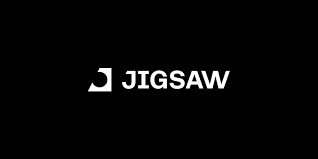

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Install Required Libraries</h1></span>

In [ ]:
!pip install --upgrade wandb

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Import Required Libraries 📚</h1></span>

In [ ]:
import os
import gc
import copy
import time
import random
import string

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Utils
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold

# For Transformer Models
from transformers import AutoTokenizer, AutoModel, AdamW

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

<img src="https://i.imgur.com/gb6B4ig.png" width="400" alt="Weights & Biases" />

<span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;"> Weights & Biases (W&B) is a set of machine learning tools that helps you build better models faster. <strong>Kaggle competitions require fast-paced model development and evaluation</strong>. There are a lot of components: exploring the training data, training different models, combining trained models in different combinations (ensembling), and so on.</span>

> <span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">⏳ Lots of components = Lots of places to go wrong = Lots of time spent debugging</span>

<span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">W&B can be useful for Kaggle competition with it's lightweight and interoperable tools:</span>

* <span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">Quickly track experiments,<br></span>
* <span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">Version and iterate on datasets, <br></span>
* <span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">Evaluate model performance,<br></span>
* <span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">Reproduce models,<br></span>
* <span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">Visualize results and spot regressions,<br></span>
* <span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">Share findings with colleagues.</span>

<span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">To learn more about Weights and Biases check out this <strong><a href="https://www.kaggle.com/ayuraj/experiment-tracking-with-weights-and-biases">kernel</a></strong>.</span>

In [ ]:
import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("wandb_api")
    wandb.login(key=api_key)
    anony = None
except:
    anony = "must"
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Training Configuration ⚙️</h1></span>

In [ ]:
def id_generator(size=12, chars=string.ascii_lowercase + string.digits):
    return ''.join(random.SystemRandom().choice(chars) for _ in range(size))

HASH_NAME = id_generator(size=12)
print(HASH_NAME)

<span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">Each experiments are grouped together using the hash-value<br></span>

![](https://i.imgur.com/Maej42h.jpg)

In [ ]:
CONFIG = {"seed": 2021,
          "epochs": 3,
          "model_name": "roberta-base",
          "train_batch_size": 32,
          "valid_batch_size": 64,
          "max_length": 128,
          "learning_rate": 1e-4,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 5,
          "n_accumulate": 1,
          "num_classes": 1,
          "margin": 0.5,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          "hash_name": HASH_NAME
          }

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])
CONFIG['group'] = f'{HASH_NAME}-Baseline'

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Set Seed for Reproducibility</h1></span>

In [ ]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

# <h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Read the Data 📖</h1>

In [ ]:
df = pd.read_csv("../input/jigsaw-toxic-severity-rating/validation_data.csv")
df.head()

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Create Folds</h1></span>

In [ ]:
skf = StratifiedKFold(n_splits=CONFIG['n_fold'], shuffle=True, random_state=CONFIG['seed'])

for fold, ( _, val_) in enumerate(skf.split(X=df, y=df.worker)):
    df.loc[val_ , "kfold"] = int(fold)
    
df["kfold"] = df["kfold"].astype(int)
df.head()

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Dataset Class</h1></span>

In [ ]:
class JigsawDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.more_toxic = df['more_toxic'].values
        self.less_toxic = df['less_toxic'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        more_toxic = self.more_toxic[index]
        less_toxic = self.less_toxic[index]
        inputs_more_toxic = self.tokenizer.encode_plus(
                                more_toxic,
                                truncation=True,
                                add_special_tokens=True,
                                max_length=self.max_len,
                                padding='max_length'
                            )
        inputs_less_toxic = self.tokenizer.encode_plus(
                                less_toxic,
                                truncation=True,
                                add_special_tokens=True,
                                max_length=self.max_len,
                                padding='max_length'
                            )
        target = 1
        
        more_toxic_ids = inputs_more_toxic['input_ids']
        more_toxic_mask = inputs_more_toxic['attention_mask']
        
        less_toxic_ids = inputs_less_toxic['input_ids']
        less_toxic_mask = inputs_less_toxic['attention_mask']
        
        
        return {
            'more_toxic_ids': torch.tensor(more_toxic_ids, dtype=torch.long),
            'more_toxic_mask': torch.tensor(more_toxic_mask, dtype=torch.long),
            'less_toxic_ids': torch.tensor(less_toxic_ids, dtype=torch.long),
            'less_toxic_mask': torch.tensor(less_toxic_mask, dtype=torch.long),
            'target': torch.tensor(target, dtype=torch.long)
        }

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Create Model</h1></span>

In [ ]:
class JigsawModel(nn.Module):
    def __init__(self, model_name):
        super(JigsawModel, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.fc = nn.Linear(768, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.drop(out[1])
        outputs = self.fc(out)
        return outputs

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Loss Function</h1></span>

![](https://i.imgur.com/qYwVt8V.jpg)

<span style="color: #000508; font-family: Segoe UI; font-size: 1.5em; font-weight: 300;">Check the official documentation <a href="https://pytorch.org/docs/stable/generated/torch.nn.MarginRankingLoss.html">here</a></span>

In [ ]:
def criterion(outputs1, outputs2, targets):
    return nn.MarginRankingLoss(margin=CONFIG['margin'])(outputs1, outputs2, targets)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Training Function</h1></span>

In [ ]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        more_toxic_ids = data['more_toxic_ids'].to(device, dtype = torch.long)
        more_toxic_mask = data['more_toxic_mask'].to(device, dtype = torch.long)
        less_toxic_ids = data['less_toxic_ids'].to(device, dtype = torch.long)
        less_toxic_mask = data['less_toxic_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = more_toxic_ids.size(0)

        more_toxic_outputs = model(more_toxic_ids, more_toxic_mask)
        less_toxic_outputs = model(less_toxic_ids, less_toxic_mask)
        
        loss = criterion(more_toxic_outputs, less_toxic_outputs, targets)
        loss = loss / CONFIG['n_accumulate']
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Validation Function</h1></span>

In [ ]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        more_toxic_ids = data['more_toxic_ids'].to(device, dtype = torch.long)
        more_toxic_mask = data['more_toxic_mask'].to(device, dtype = torch.long)
        less_toxic_ids = data['less_toxic_ids'].to(device, dtype = torch.long)
        less_toxic_mask = data['less_toxic_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = more_toxic_ids.size(0)

        more_toxic_outputs = model(more_toxic_ids, more_toxic_mask)
        less_toxic_outputs = model(less_toxic_ids, less_toxic_mask)
        
        loss = criterion(more_toxic_outputs, less_toxic_outputs, targets)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])   
    
    gc.collect()
    
    return epoch_loss

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Run Training</h1></span>

In [ ]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        
        # Log the metrics
        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Valid Loss": val_epoch_loss})
        
        # deep copy the model
        if val_epoch_loss <= best_epoch_loss:
            print(f"{b_}Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            run.summary["Best Loss"] = best_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"Loss-Fold-{fold}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [ ]:
def prepare_loaders(fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = JigsawDataset(df_train, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])
    valid_dataset = JigsawDataset(df_valid, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [ ]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

<span style="color: #000508; font-family: Segoe UI; font-size: 1.5em; font-weight: 300;">Start Training</span>

In [ ]:
for fold in range(0, CONFIG['n_fold']):
    print(f"{y_}====== Fold: {fold} ======{sr_}")
    run = wandb.init(project='Jigsaw', 
                     config=CONFIG,
                     job_type='Train',
                     group=CONFIG['group'],
                     tags=['roberta-base', f'{HASH_NAME}', 'margin-loss'],
                     name=f'{HASH_NAME}-fold-{fold}',
                     anonymous='must')
    
    # Create Dataloaders
    train_loader, valid_loader = prepare_loaders(fold=fold)
    
    model = JigsawModel(CONFIG['model_name'])
    model.to(CONFIG['device'])
    
    # Define Optimizer and Scheduler
    optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
    scheduler = fetch_scheduler(optimizer)
    
    model, history = run_training(model, optimizer, scheduler,
                                  device=CONFIG['device'],
                                  num_epochs=CONFIG['epochs'],
                                  fold=fold)
    
    run.finish()
    
    del model, history, train_loader, valid_loader
    _ = gc.collect()
    print()

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Visualizations</h1></span>

<span style="color: #000508; font-family: Segoe UI; font-size: 1.5em; font-weight: 300;"><a href="https://wandb.ai/dchanda/Jigsaw">View the Complete Dashboard Here ⮕</a></span>

![](https://i.imgur.com/TSIUdfS.jpg)

![Upvote!](https://img.shields.io/badge/Upvote-If%20you%20like%20my%20work-07b3c8?style=for-the-badge&logo=kaggle)